In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from datetime import datetime
from tqdm import tqdm

from os import listdir
from os.path import isfile, join

from MSsmoothing import smoothMS
import rmnoise as rmno

rootfolder="/home/aulegoup/Optical_fibers/Absorption_spectra_experiments/"

# Extract all from folder

In [2]:
NameFoldExtract="2024-05-10 - sample B new test post thermal annealing"
NameSubFoldTemp="Temperature data"
NameCSVforTemp="2024-05-10 Fri 13h06min59s - fiber T curve - dur 7347s.csv"
firstfilenb=0

{'Name2Id': {'W20240510_130930.CSV': 0}, 'Id2Name': {0: 'W20240510_130930.CSV'}, 'Id2Datetime': {0: datetime.datetime(2024, 5, 10, 13, 9, 30, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400)))}, 'Id2WL': {}, 'Id2LEVEL': {}}
Sweep period : 2.340 seconds


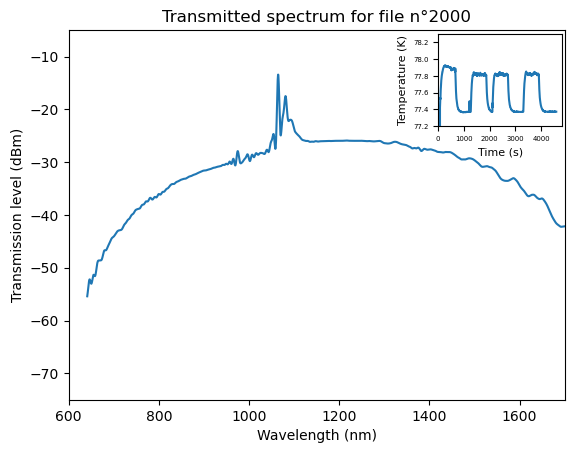

100%|███████████████████████████████████████████████████████████████████████████████| 7479/7479 [02:13<00:00, 56.01it/s]


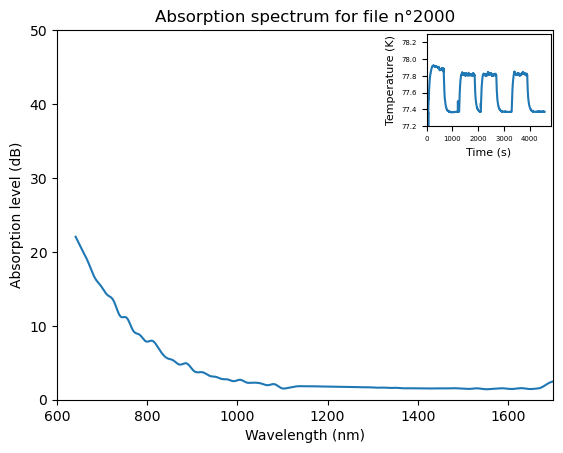

In [3]:
#######################################################################################################
#First, let's extract all the time information from the filenames.
#######################################################################################################

mypath=join(rootfolder,NameFoldExtract)
LISTFILES = sorted([f for f in listdir(mypath) if isfile(join(mypath, f))])[firstfilenb:]
Nfiles=len(LISTFILES)

#List file properties
FPROP={
    "Name2Id":{},
    "Id2Name":{},
    "Id2Datetime":{},
    "Id2WL":{},
    "Id2LEVEL":{}
}
for i,f in enumerate(LISTFILES):
    DATE=f.split('_')[0].split('W')[1]
    YY=DATE[:4]
    MM=DATE[4:6]
    DD=DATE[6:8]
    H=f.split('.')[0].split('_')[1][:2]
    M=f.split('.')[0].split('_')[1][2:4]
    S=f.split('.')[0].split('_')[1][4:6]
    ISOTIME=f"{YY}-{MM}-{DD}T{H}:{M}:{S}-05:00"
    FPROP["Name2Id"][f]=i
    FPROP["Id2Name"][i]=f
    FPROP["Id2Datetime"][i]=datetime.fromisoformat(ISOTIME)
    if i==0:
        print(FPROP)

def Timedeltaseconds_f(i1,i0=0):
    return (FPROP["Id2Datetime"][i1]-FPROP["Id2Datetime"][i0]).seconds

Tsweep=Timedeltaseconds_f(Nfiles-1)/(Nfiles-1)
#Tsweep=4+22300/20442
print(f"Sweep period : {Tsweep:.3f} seconds")

#######################################################################################################
#Now, let's extract the spectra from the files:
#######################################################################################################

for i in range(Nfiles):
    with open(join(mypath,FPROP["Id2Name"][i]),'r') as f:
            LINES=f.readlines()
            N=len(LINES)
            n=0
            while "[TRACE DATA]" not in LINES[n]:
                n+=1
            WL_nm,LEVEL_dBm=[],[]
            for j in range(n+1,N):
                l=LINES[j]
                if '.' in l:
                    wl=float((l.split(','))[0])
                    lvl=float((l.split(','))[1])
                    if wl>=600 and wl<=1700:
                        WL_nm+=[wl]
                        LEVEL_dBm+=[lvl]
    if i==0:
        WL_nm0=WL_nm
    elif WL_nm0!=WL_nm:
        raise NameError(f"WL difference at id {i}")
    FPROP["Id2LEVEL"][i]=np.array(LEVEL_dBm)

WL_nm=np.array(WL_nm)


#######################################################################################################
#Let's extract the temperature data:
#######################################################################################################
Tpath=join(join(mypath,NameSubFoldTemp),NameCSVforTemp)
with open(Tpath,'r') as f:
    LINES_T=f.readlines()
    N_T=len(LINES_T)
    TIME_T,TEMP=[],[]
    for i in range(N_T):
        l=LINES_T[i]
        if '.' in l:
            sec,temp=float((l.split(','))[0]),float((l.split(','))[1])
            TIME_T+=[sec]
            TEMP+=[temp]

def TimetoTempindex(t):
    return next(x for x,sec in enumerate(TIME_T) if sec>t)

#######################################################################################################
#Test plots
#######################################################################################################
if False:
    idtest=0
    
    plt.figure()
    plt.plot(WL_nm,FPROP["Id2LEVEL"][idtest])
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Level (dBm)")
    plt.title(f"Transmitted spectrum for file n°{idtest}")
    plt.ylim(-75,-5)
    plt.show
    
    idtest=Nfiles-1
    
    plt.figure()
    plt.plot(WL_nm,FPROP["Id2LEVEL"][idtest])
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Transmission level (dBm)")
    plt.title(f"Transmitted spectrum for file n°{idtest}")
    plt.ylim(-75,-5)
    plt.show()

#######################################################################################################
#Test plots with T subplot
#######################################################################################################
def add_subplot_axes(ax,rect,axisbg='w'):
    #https://stackoverflow.com/questions/17458580/embedding-small-plots-inside-subplots-in-matplotlib
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height])#,facecolor=facecolor)  # matplotlib 2.0+
    #subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax
    
# idtest=0
# idtest=Nfiles-1
idtest=2000

n,m=6,150 #NEW

fig, ax = plt.subplots()
# ax.plot(WL_nm,FPROP["Id2LEVEL"][idtest])
I=rmno.firstid(FPROP["Id2LEVEL"][idtest]) #NEW
ax.plot(WL_nm[I:],smoothMS(FPROP["Id2LEVEL"][idtest][I:],n,m)) #NEW
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transmission level (dBm)")
ax.set_title(f"Transmitted spectrum for file n°{idtest}")
ax.set_ylim(-75,-5)
ax.set_xlim(600,1700) #NEW
#New:
subax = add_subplot_axes(ax,[0.745,0.74,0.25,0.25])
id_cut=TimetoTempindex(Timedeltaseconds_f(idtest))
subax.plot(TIME_T[:id_cut],TEMP[:id_cut])
subax.set_xlim(left=0)
subax.set_xlabel("Time (s)",fontsize=8)
subax.set_ylabel("Temperature (K)",fontsize=8)
subax.set_ylim(bottom=77.2)
plt.show()

#######################################################################################################
#Add absorption spectra
#######################################################################################################

FPROP["firstid"]={}
FPROP["Id2ABS"]={}
BASESp=FPROP["Id2LEVEL"][0]
lendata=len(WL_nm)
for i in tqdm(range(Nfiles)):
    I=rmno.firstid(FPROP["Id2LEVEL"][i], half_width_test = 40, noise_threshold = -75)
    if lendata-I<83:#25:
        I=lendata
        FPROP["Id2ABS"][i]=np.array([])
    else:
        FPROP["Id2ABS"][i]=smoothMS(BASESp[I:],n,m=500)-smoothMS(FPROP["Id2LEVEL"][i][I:],n,m=500)
        # FPROP["Id2ABS"][i]=smoothMS(BASESp[I:]-FPROP["Id2LEVEL"][i][I:],n,m=150)
        # FPROP["Id2ABS"][i]=smoothMS(BASESp[I:]-FPROP["Id2LEVEL"][i][I:],n,m=500)
        # FPROP["Id2ABS"][i]=BASESp[I:]-FPROP["Id2LEVEL"][i][I:]
    FPROP["firstid"][i]=I

fig, ax = plt.subplots()
ax.plot(WL_nm[FPROP["firstid"][idtest]:],FPROP["Id2ABS"][idtest])
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Absorption level (dB)")
ax.set_title(f"Absorption spectrum for file n°{idtest}")
ax.set_ylim(0,50)
ax.set_xlim(600,1700) #NEW
#New:
subax = add_subplot_axes(ax,[0.745,0.74,0.25,0.25])
id_cut=TimetoTempindex(Timedeltaseconds_f(idtest))
subax.plot(TIME_T[:id_cut],TEMP[:id_cut])
subax.set_xlim(left=0)
subax.set_xlabel("Time (s)",fontsize=8)
subax.set_ylabel("Temperature (K)",fontsize=8)
subax.set_ylim(bottom=77.2)
plt.show()

# Create an animation.

### Animation of the transmitted spectrum

In [ ]:
fig, ax = plt.subplots()
I = rmno.firstid(FPROP["Id2LEVEL"][0])
Line, = ax.plot(WL_nm[I:], smoothMS(FPROP["Id2LEVEL"][0][I:],n,m))
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transmission level (dBm(tocheck))")
ax.set_title(f"Transmitted spectrum after {0*Tsweep/60:.2f} minutes")
ax.set_ylim(-75, -5)
ax.set_xlim(600,1700)
#New
subax = add_subplot_axes(ax,[0.745,0.74,0.25,0.25])
Subline = subax.plot(TIME_T[:1],TEMP[:1])
subax.set_xlim(0,int(TIME_T[-1])+1)
subax.set_xlabel("Time (s)",fontsize=8)
subax.set_ylabel("Temperature (K)",fontsize=8)

def update(frame):
    try:
        I = rmno.firstid(FPROP["Id2LEVEL"][frame])
        # print(len(FPROP["Id2LEVEL"][frame])-I)
        Line.set_xdata(WL_nm[I:])
        try:
            Line.set_ydata(smoothMS(FPROP["Id2LEVEL"][frame][I:],n,m))
        except ValueError:
            Line.set_ydata(FPROP["Id2LEVEL"][frame][I:])
    except StopIteration or ValueError :
        Line.set_xdata([])
        Line.set_ydata([])
    ax.set_title(f"Transmitted spectrum after {frame * Tsweep / 60:.2f} minutes")
    id_cut=TimetoTempindex(Timedeltaseconds_f(frame))
    Subline[0].set_xdata(TIME_T[:id_cut])
    Subline[0].set_ydata(TEMP[:id_cut])
    return Line,Subline[0],

ani = animation.FuncAnimation(fig=fig, func=update, frames=Nfiles - 1, interval=30)
# HTML(ani.to_jshtml())
ani.save(join(rootfolder,f"Animation - transmission - {NameFoldExtract} - with filt.gif"))

### Animation of the transmitted spectrum - extract

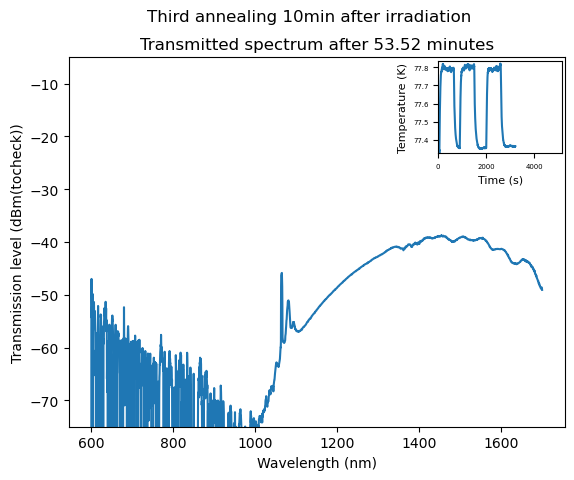

In [94]:
first_id = 1397
last_id = 1478
tune_interval = 300
extract_title = "Third annealing 10min after irradiation"

fig, ax = plt.subplots()
Line, = ax.plot(WL_nm, FPROP["Id2LEVEL"][0])
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transmission level (dBm(tocheck))")
fig.suptitle(extract_title,fontsize=12)
ax.set_title(f"Transmitted spectrum after {0*Tsweep/60:.2f} minutes",fontsize=10)
ax.set_ylim(-75, -5)
#New
subax = add_subplot_axes(ax,[0.745,0.74,0.25,0.25])
id_cut=TimetoTempindex(Timedeltaseconds_f(first_id))
Subline = subax.plot(TIME_T[:id_cut],TEMP[:id_cut])
subax.set_xlim(0,int(TIME_T[-1])+1)
subax.set_ylim(min(TEMP),max(TEMP))
subax.set_xlabel("Time (s)",fontsize=8)
subax.set_ylabel("Temperature (K)",fontsize=8)

def update(frame):
    Line.set_ydata(FPROP["Id2LEVEL"][frame+first_id])
    ax.set_title(f"Transmitted spectrum after {(frame+first_id) * Tsweep / 60:.2f} minutes")
    id_cut=TimetoTempindex(Timedeltaseconds_f(frame+first_id))
    Subline[0].set_xdata(TIME_T[:id_cut])
    Subline[0].set_ydata(TEMP[:id_cut])
    return Line,Subline[0],

ani = animation.FuncAnimation(fig=fig, func=update, frames=last_id-first_id+1, interval=30)
HTML(ani.to_jshtml())
ani.save(join(rootfolder,f"Animation - transmission - {NameFoldExtract} - extract - {extract_title} - inter {tune_interval}.gif"))

### Animation of the transmitted spectrum - extract - 3 moments together

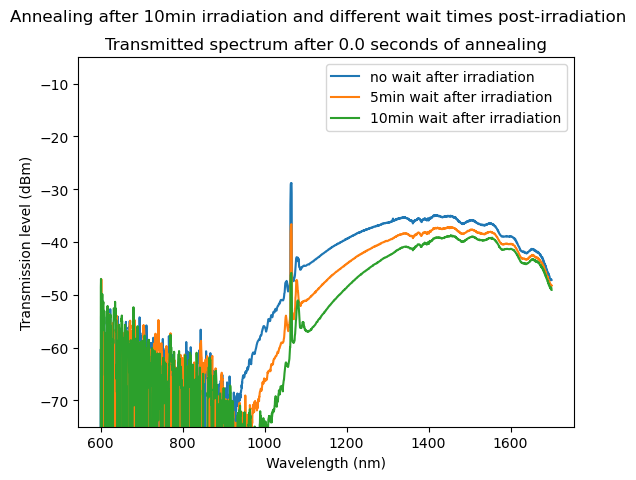

In [100]:
FIRST_IDS = [287,787,1397]
LABELS = ["no wait after irradiation","5min wait after irradiation","10min wait after irradiation"]
N_frames = 82
tune_interval = 1000
extract_title = "Annealing after 10min irradiation and different wait times post-irradiation"

fig, ax = plt.subplots()
LINES = [ax.plot(WL_nm, FPROP["Id2LEVEL"][ID],label=LABELS[i]) for i,ID in enumerate(FIRST_IDS)]
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transmission level (dBm)")
fig.suptitle(extract_title,fontsize=12)
ax.set_title(f"Transmitted spectrum after {0*Tsweep:.1f} seconds of annealing",fontsize=10)
ax.set_ylim(-75, -5)
ax.legend()

if False:
    def update(frame):
        for i in range(len(FIRST_IDS)):
            LINES[i][0].set_ydata(FPROP["Id2LEVEL"][frame+FIRST_IDS[i]])
        ax.set_title(f"Transmitted spectrum after {(frame) * Tsweep :.1f} seconds of annealing")
        return LINES
    
    ani = animation.FuncAnimation(fig=fig, func=update, frames=N_frames, interval=30)
    HTML(ani.to_jshtml())
    ani.save(join(rootfolder,f"Animation - transmission - {NameFoldExtract} - extract - {extract_title} - inter {tune_interval}.gif"))
else:
    fig.set_dpi(1000)
    plt.show()

### Transmitted spectrum - multiple moments together without animation

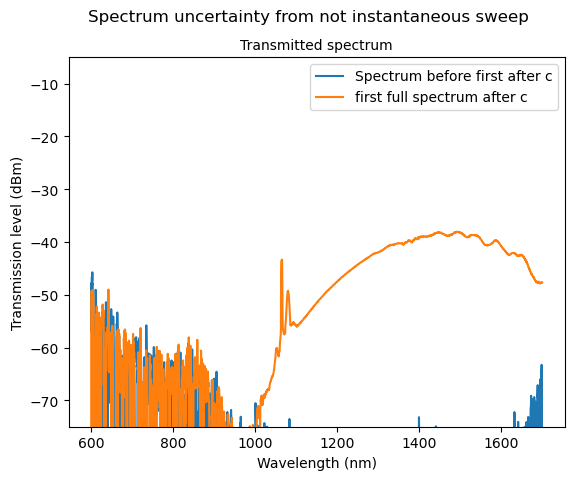

In [133]:
FIRST_IDS = [1312,1313]
LABELS = ["Spectrum before first after c","first full spectrum after c"]
extract_title = "Spectrum uncertainty from not instantaneous sweep"
filenameplot = "2024-05-10 - Tsweep uncertainty c.png" 
SAVE=True

fig, ax = plt.subplots()
LINES = [ax.plot(WL_nm, FPROP["Id2LEVEL"][ID],label=LABELS[i]) for i,ID in enumerate(FIRST_IDS)]
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transmission level (dBm)")
fig.suptitle(extract_title,fontsize=12)
# ax.set_title(f"Transmitted spectrum after {0*Tsweep:.1f} seconds of annealing",fontsize=10)
ax.set_title(f"Transmitted spectrum",fontsize=10)
ax.set_ylim(-75, -5)
ax.legend()
if not(SAVE):
    plt.show()
if SAVE:
    plt.savefig(filenameplot)

### Animation of the absorption spectrum

Animation size has reached 21015913 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


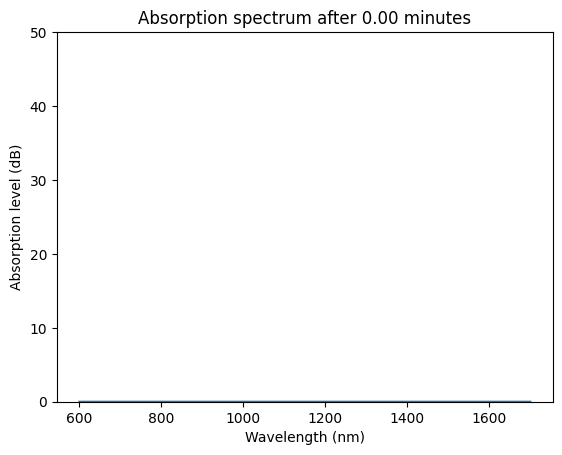

In [7]:
fig, ax = plt.subplots()
Line, = ax.plot(WL_nm, FPROP["Id2ABS"][0])
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Absorption level (dB)")
ax.set_title(f"Transmitted spectrum for file after {0*Tsweep/60:.2f} minutes")
ax.set_ylim(0,50)

def update(frame):
    Line.set_ydata(FPROP["Id2ABS"][frame])
    ax.set_title(f"Absorption spectrum after {frame * Tsweep / 60:.2f} minutes")
    return Line,

ani = animation.FuncAnimation(fig=fig, func=update, frames=Nfiles - 1, interval=30)
HTML(ani.to_jshtml())
ani.save(join(rootfolder,f"Animation - absorption - {NameFoldExtract}.gif"))

### Animation of the absorption spectrum (excerpt and test filtering)

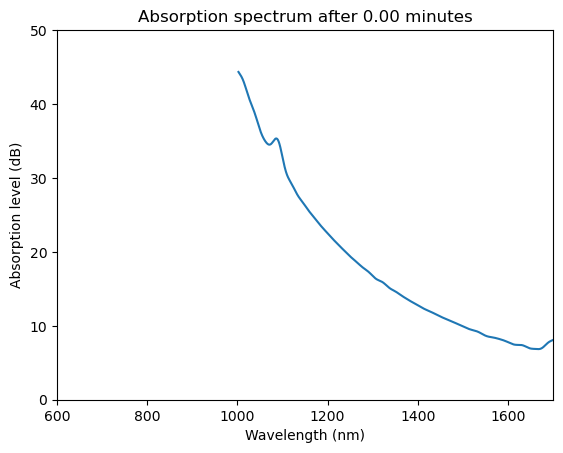

In [23]:
start,end=1968,2046
fig, ax = plt.subplots()
I=FPROP["firstid"][start]
Line, = ax.plot(WL_nm[I:], FPROP["Id2ABS"][start])
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Absorption level (dB)")
ax.set_title(f"Transmitted spectrum for file after {0*Tsweep/60:.2f} minutes")
ax.set_ylim(0,50)
ax.set_xlim(600,1700)

def update(frame):
    I=FPROP["firstid"][frame+start]
    Line.set_xdata(WL_nm[I:])
    Line.set_ydata(FPROP["Id2ABS"][frame+start])
    ax.set_title(f"Absorption spectrum after {frame * Tsweep / 60:.2f} minutes")
    return Line,

ani = animation.FuncAnimation(fig=fig, func=update, frames=end-start, interval=30)
HTML(ani.to_jshtml())
ani.save(join(rootfolder,f"Animation - absorption - {NameFoldExtract} - extract - filt both m500.gif"))

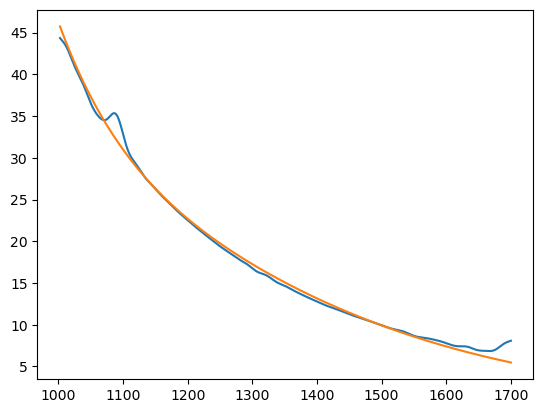

In [5]:
import gaussdec as GD

start,end=1968,2046
fig, ax = plt.subplots()
I=FPROP["firstid"][start]
Line, = ax.plot(WL_nm[I:], FPROP["Id2ABS"][start])

# testbands="STH1"
# if testbands in GD.DICOPEAKS.keys():
#     PEAKS=GD.DICOPEAKS[testbands]
# elif testbands in GD.DICOIMPUR.keys():
#     PEAKS=GD.DICOIMPUR[testbands]
# else:
#     PEAKS=[]
# for peak in PEAKS:
#     if type(peak["FWHM"])==float:
#         fwhm=peak["FWHM"]
#     elif peak["FWHM"]==None:
#         fwhm=1e-6
#     else:
#         fwhm=(peak["FWHM"]["min"]+peak["FWHM"]["max"])/2
#     ax.plot(WL_nm[I:], GD.gaussband(WL_nm[I:],100,peak["peak"],fwhm))
# ax.set_yscale("log")

# ListDefects = ["STH1","STH2","Composite 1-eV band","E-prime","ODC-I",] #["ODC-II","NBOHC","POL"]
ListDefects = ["STH1","STH2","Composite 1-eV band","E-prime","ODC-I","ODC-II","NBOHC"] #[,"POL"]
# ListDefects = ["STH1","NBOHC","STH2"]#,"Composite 1-eV band","E-prime","ODC-I","ODC-II"] #[,"POL"]

popt,pcov=GD.decompose(WL_nm[I:],FPROP["Id2ABS"][start],LTIRA=False,GaussList=ListDefects,relmaxfev=200,defaultmag=1) 
plt.plot(WL_nm[I:],GD.totabs(WL_nm[I:],*popt))
plt.show()

In [6]:
print("Position of LTIRA parameters : (0,4)")
cntpeaks=0
for i,dfct in enumerate(ListDefects):
    nbpeaks=len(GD.DICOPEAKS[dfct])
    print(f"Position of {dfct} parameters : {5+cntpeaks*3,5+(cntpeaks+nbpeaks)*3-1}")
    cntpeaks+=nbpeaks

Position of LTIRA parameters : (0,4)
Position of STH1 parameters : (5, 10)
Position of STH2 parameters : (11, 16)
Position of Composite 1-eV band parameters : (17, 22)
Position of E-prime parameters : (23, 25)
Position of ODC-I parameters : (26, 28)
Position of ODC-II parameters : (29, 37)
Position of NBOHC parameters : (38, 46)


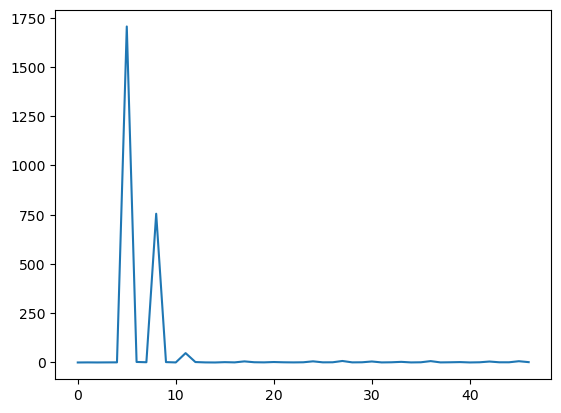

In [7]:
# magn=[0]+[5+3*i for i in range((len(popt)-5)//3)]
# plt.plot(magn,popt[magn])
plt.plot(popt)
plt.show()
# plt.plot(magn,np.sqrt(np.diag(pcov)[magn]))
# plt.show()

Position of STH1 parameters : (5, 10)
peak 0 : magnitude 1705.64
peak 1 : magnitude 755.09
Position of STH2 parameters : (11, 16)
peak 0 : magnitude 47.52
peak 1 : magnitude 0.00
Position of Composite 1-eV band parameters : (17, 22)
peak 0 : magnitude 5.54
peak 1 : magnitude 2.27
Position of E-prime parameters : (23, 25)
peak 0 : magnitude 1.00
Position of ODC-I parameters : (26, 28)
peak 0 : magnitude 1.00
Position of ODC-II parameters : (29, 37)
peak 0 : magnitude 1.00
peak 1 : magnitude 1.00
peak 2 : magnitude 1.00
Position of NBOHC parameters : (38, 46)
peak 0 : magnitude 1.00
peak 1 : magnitude 1.00
peak 2 : magnitude 1.00


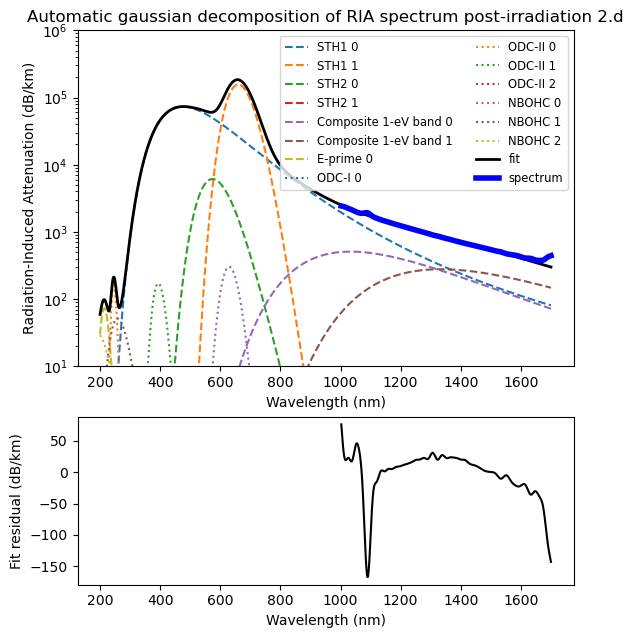

In [35]:
WLrange = np.linspace(200,1700,1000)

COLORS=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:olive']#,'tab:pink','tab:gray','tab:cyan']
linestyles=["dashed","dotted","dashdot"]

fig, axs = plt.subplots(2, figsize=[6.4, 4.8*1.5], gridspec_kw={'height_ratios': [2, 1]})
# fig.set_dpi(1000)

length=18.24/1000 #km

for scale in ["log"]: #"linear",
    cntpeaks=0
    maxmag=np.max(popt)
    for i,dfct in enumerate(ListDefects):
        nbpeaks=len(GD.DICOPEAKS[dfct])
        print(f"Position of {dfct} parameters : {5+cntpeaks*3,5+(cntpeaks+nbpeaks)*3-1}")
        for j in range(nbpeaks):
            mag=popt[5+(cntpeaks+j)*3]
            if True:#mag/maxmag>1e-2:
                print(f"peak {j} : magnitude {mag:.2f}")
                partpopt = popt[5+(cntpeaks+j)*3 : 5+(cntpeaks+j+1)*3]
                num=cntpeaks+j
                               
                axs[0].plot(WLrange,GD.gaussband(WLrange,*partpopt)/length,label=f"{dfct} {j}",linestyle=linestyles[num//len(COLORS)],color=COLORS[num%len(COLORS)])
        cntpeaks+=nbpeaks
    
    axs[0].plot(WLrange,GD.totabs(WLrange,*popt)/length,label="fit",linewidth=2, color = 'k')
    axs[0].plot(WL_nm[I:], FPROP["Id2ABS"][start]/length,label="spectrum",linewidth=4, color ="blue")
    axs[0].legend(fontsize="small",loc="upper right",ncol=2)
    # plt.xscale(scale)
    axs[0].set_yscale(scale)
    if scale=="log":
        axs[0].set_ylim(1e1,1e6)
    xlim=axs[0].get_xlim()
    axs[0].set_ylabel("Radiation-Induced Attenuation (dB/km)")
    axs[0].set_xlabel("Wavelength (nm)")
    # print(xlim)
axs[1].plot(WL_nm[I:],(GD.totabs(WL_nm[I:],*popt)-FPROP["Id2ABS"][start])/length, color='k')#,label="residual")
axs[1].set_xlim(xlim)
axs[1].set_xlabel("Wavelength (nm)")
axs[1].set_ylabel("Fit residual (dB/km)")
axs[0].set_title("Automatic gaussian decomposition of RIA spectrum post-irradiation 2.d")
# axs[1].legend()
plt.show()
# plt.savefig("GaussianDecomp2d.pdf")

In [9]:
print(popt)

[1.25697546e-08 3.89999999e-01 1.10000007e-01 4.30000015e-01
 6.49999991e-01 1.70563944e+03 2.60999870e+00 1.20000060e+00
 7.55088995e+02 1.88000038e+00 2.49038014e-01 4.75196262e+01
 2.16000019e+00 3.99530595e-01 9.82702592e-06 1.63000026e+00
 4.75328132e-01 5.53551697e+00 1.20000060e+00 5.60000280e-01
 2.26984896e+00 9.29999535e-01 4.20000210e-01 9.99999986e-01
 5.79999998e+00 7.00000007e-01 1.00000001e+00 7.60000000e+00
 5.50000004e-01 1.00000001e+00 5.05000001e+00 3.20000013e-01
 1.00000001e+00 3.15000001e+00 3.00000007e-01 9.99999993e-01
 6.90000000e+00 4.00000008e-01 1.00000000e+00 1.97000001e+00
 1.70000008e-01 9.99999996e-01 4.80000000e+00 1.00000001e+00
 1.00000001e+00 6.39999998e+00 1.70000000e+00]


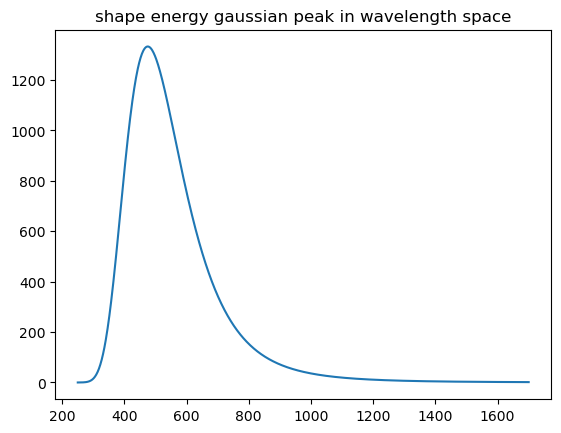

In [10]:
rangetest=np.linspace(250,1700,1000)
plt.plot((rangetest),GD.gaussband(rangetest,1.70253858e+03, 2.60999870e+00, 1.20000060e+00)) #GD.WLnm2eV
plt.title("shape energy gaussian peak in wavelength space")
plt.show()